In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.offline as py
#import plotly.graph_objs as go
import string
import os
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# This next import is for some date functions I created
import timefuns as tf

In [2]:
stageDatesTur = pd.read_csv("renfe_lowest_price.csv", dtype = 'str')

In [3]:
stageDatesTur['weekday_num'] = stageDatesTur['weekday'].apply(tf.weekdayNum)
stageDatesTur['days_num'] = stageDatesTur['start_date'].apply(tf.daysNum)
stageDatesTur['hour_num'] = stageDatesTur['start_date'].apply(tf.getHourFloat)/24

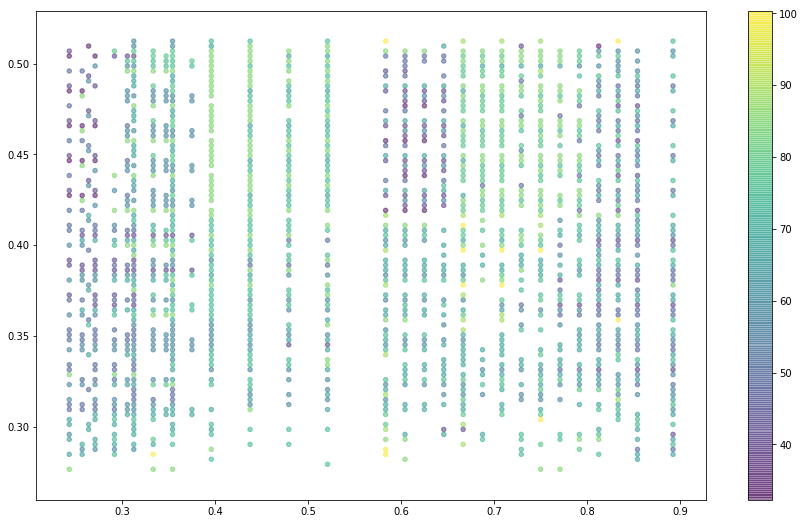

In [4]:
fig = plt.figure(figsize=(15, 9))

x = stageDatesTur['hour_num']
y = stageDatesTur['days_num']
colors = stageDatesTur['lowest_price']
area = 20

sc = plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.colorbar(sc)
plt.show()

In [5]:
m = stageDatesTur.shape[0]

In [6]:
X1 = np.array(stageDatesTur['hour_num'])
X2 = np.array(stageDatesTur['weekday_num'])
X3 = np.array(stageDatesTur['days_num'])
Y = np.array(stageDatesTur['lowest_price']).real.astype(float)
XY = np.transpose(np.array([np.ones(m), X1, X2, X3, Y]))

In [7]:
np.random.seed(0)
np.random.shuffle(XY)

X = XY[:, :4]
Y = XY[:, 4]
Y = Y.reshape(Y.shape[0], 1)

Train/test/validate split

In [8]:
X.shape

(1592, 4)

In [9]:
def trainTestValSplit(X, Y):
    m = X.shape[0]
    
    X_train = X[:m*6//10]
    Y_train = Y[:m*6//10]
    X_cv = X[m*6//10:m*8//10]
    Y_cv = Y[m*6//10:m*8//10]
    X_test = X[m*8//10:]
    Y_test = Y[m*8//10:]
    
    return X_train, Y_train, X_cv, Y_cv, X_test, Y_test
    

In [10]:
X_train, Y_train, X_cv, Y_cv, X_test, Y_test = trainTestValSplit(X, Y)
print(X_train.shape, X_cv.shape, X_test.shape)

(955, 4) (318, 4) (319, 4)


In [11]:
reg = linear_model.LinearRegression(fit_intercept = False)
reg.fit(X_train, Y_train)
theta = reg.coef_

In [12]:
def costFunction(X, Y, theta, lamb=0):
    return (np.sum((np.dot(X,theta.T) - Y)**2) + lamb*np.sum(theta**2))/(2*X.shape[0])

In [13]:
(Y_train).shape

(955, 1)

In [14]:
costFunction(X_test, Y_test, theta)

92.08248915609875

Learning Curves

In [15]:
def learningCurves(X_train, Y_train, X_cv, Y_cv, n_iters, lamb=0):
    m = min(X_train.shape[0], X_cv.shape[0])
    errors = np.zeros([m, 3])
    error_train = 0
    error_val = 0
    
    reg = linear_model.LinearRegression(fit_intercept = False)
    
    for i in range(m):
        for j in range(n_iters):
            c = np.random.permutation(X_train.shape[0])
            c = c[:i+1]
            Xsamp = X[c]
            Ysamp = Y[c]
            
            cval = np.random.permutation(X_cv.shape[0])
            cval = cval[:i+1]
            Xvalsamp = X[cval]
            Yvalsamp = Y[cval]

            reg.fit(Xsamp, Ysamp)
            theta = reg.coef_
            error_train = error_train + costFunction(Xsamp, Ysamp, theta, lamb)
            error_val = error_val + costFunction(Xvalsamp, Yvalsamp, theta, lamb)
            
        error_train = error_train/n_iters
        error_val = error_val/n_iters
        errors[i] = np.array([i+1, error_train, error_val])
        
    return errors

In [16]:
X_train.shape[0]

955

In [17]:
errors = learningCurves(X_train, Y_train, X_cv, Y_cv, 50, 0)

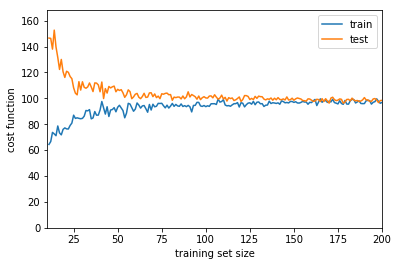

In [18]:
m_min = 10
m_max = 200
y_max = np.max(errors[m_min:m_max, 1:3])*1.1

plt.plot(errors[m_min:m_max, 0], errors[m_min:m_max, 1], label='train')
plt.plot(errors[m_min:m_max, 0], errors[m_min:m_max, 2], label='test')
plt.xlim(m_min, m_max)
plt.ylim(0, y_max)
plt.xlabel('training set size')
plt.ylabel('cost function')
plt.legend()

In [19]:
errors.shape

(318, 3)

Adding polynomial features

In [37]:
def trainPoly(X, Y, degree, lamb=0, curves = False):
    # Generate polynomial features
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X[:, 1:])
    
    # Test/CV/Train split on the new dataset
    X_train_poly, Y_train_poly, X_cv_poly, Y_cv_poly,\
    X_test_poly, Y_test_poly = trainTestValSplit(X_poly, Y)
    
    # Learning curves
    if curves:
        errors_poly = learningCurves(X_train_poly, Y_train_poly,\
                                     X_cv_poly, Y_cv_poly, 50, 0)
        
        # Plot the curves (should be its own function)
        
        m_min = 10
        m_max = 300
        y_max = np.max(errors_poly[m_min:m_max, 1:3])*1.1

        plt.plot(errors_poly[m_min:m_max, 0], errors_poly[m_min:m_max, 1], label='train')
        plt.plot(errors_poly[m_min:m_max, 0], errors_poly[m_min:m_max, 2], label='test')
        plt.xlim(m_min, m_max)
        plt.ylim(0, y_max)
        plt.xlabel('training set size')
        plt.ylabel('cost function')
        plt.legend()
    
    # Train the model
    reg.fit(X_train_poly, Y_train_poly)
    theta = reg.coef_
    
    # Print cost functions
    # print("Training cost function:", costFunction(X_train_poly, Y_train_poly, theta, lamb))
    # print("CV cost function:", costFunction(X_cv_poly, Y_cv_poly, theta, lamb))
    # print("Test cost function:", costFunction(X_test_poly, Y_test_poly, theta, lamb))
    
    return {"X_train": X_train_poly, "X_cv": X_cv_poly, "X_test": X_test_poly,\
            "Y_train": Y_train_poly, "Y_cv": Y_cv_poly, "Y_test": Y_test_poly}, theta

In [39]:
predict = np.dot(data['X_cv'], theta.T)
np.abs(predict[5:25] - Y[5:25])

array([[ 3.28785553],
       [ 6.49970703],
       [55.49975128],
       [20.05312927],
       [12.73966225],
       [16.05499277],
       [10.26866608],
       [27.34989014],
       [27.53975563],
       [ 1.37444458],
       [16.5136734 ],
       [15.90595398],
       [ 8.47948608],
       [10.3813385 ],
       [ 5.52858734],
       [ 2.86259766],
       [13.51356659],
       [12.50360107],
       [ 8.58026428],
       [ 5.40805664]])

In [58]:
def optimizeDegree(X, Y, lamb = 0, degmax = 15, plot=True):
    J_train = []
    J_cv = []
    for i in range(degmax+1):
        data, theta = trainPoly(X, Y, i)
        J_train.append(costFunction(data["X_train"], data["Y_train"], theta, lamb))
        J_cv.append(costFunction(data["X_cv"], data["Y_cv"], theta, lamb))
        
    if plot:
        plt.plot(range(degmax+1), J_train, label='train')
        plt.plot(range(degmax+1), J_cv, label='test')
        plt.ylim(0, 1.1*J_cv[0])
        plt.xlabel('degree')
        plt.ylabel('cost function')
        plt.legend()
        

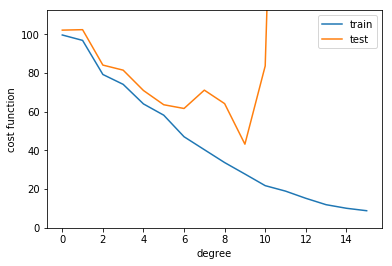

In [60]:
optimizeDegree(X, Y, 0, 15)

Degree 9 polynomial features seem to minimize the cost in the cross-validation set

In [61]:
data, theta = trainPoly(X, Y, 9)

Which produces a root mean square error of about

In [63]:
np.sqrt(2*costFunction(data["X_test"], data["Y_test"], theta))

10.650536847639597

Next we plot the error between each predicted point and the test set back in the schedule graph

In [80]:
prediction = np.dot(data["X_test"], theta.T)

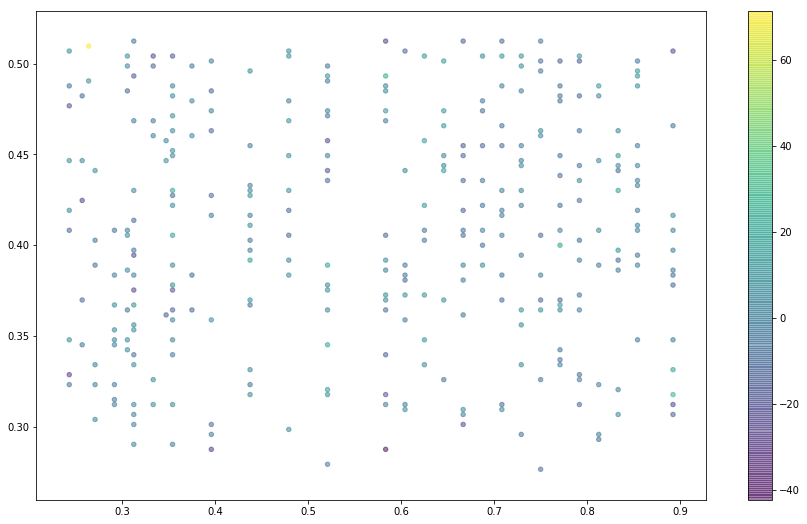

In [88]:
fig = plt.figure(figsize=(15, 9))

x = list(data["X_test"][:,1])
y = list(data["X_test"][:,3])
colors = list(prediction[:,0] - data["Y_test"][:,0])
area = 20

sc = plt.scatter(x, y, s=area, c=colors, alpha=0.5)
cbar = plt.colorbar(sc)
#plt.colorbar(sc)
plt.show()